In [1]:
import sys
import torch
sys.path.append('../')

# Reference

In [2]:
from humancompatible.interconnect.simulators.nodes.reference import ReferenceSignal

refsig = ReferenceSignal(name="r")
refsig.set_reference_signal(300)

# Aggregator

In [3]:
from humancompatible.interconnect.simulators.nodes.aggregator import Aggregator

class AggregatorLogic1:
    def __init__(self):
        self.tensors = []
        self.result = None
        
    def forward(self, values):
        if type(values) is not list:
            values = [values]
        self.tensors = values
        result = torch.sum(torch.stack([torch.sum(t.detach().clone().requires_grad_()) for t in self.tensors])).unsqueeze(dim=0)
        self.result = result
        return result

class AggregatorLogic2:
    def __init__(self):
        self.tensors = []
        
    def forward(self, values):
        if type(values) is not list:
            values = [values]
        self.tensors = values
        result = torch.sum(torch.stack([torch.sum(t) for t in self.tensors])).unsqueeze(dim=0) 
        return result
    
agg1 = Aggregator(name="A1", logic=AggregatorLogic1())
agg2 = Aggregator(name="A2", logic=AggregatorLogic2())

# Controller

In [4]:
from humancompatible.interconnect.simulators.nodes.controller import Controller

class PiControllerLogic(torch.nn.Module):
    def __init__(self, kp, ki):
        super().__init__()
        self.tensors = {
                        "e": torch.tensor([0.0], requires_grad=True),
                        "x": torch.tensor([0.0], requires_grad=True)}
        self.kp = torch.nn.Parameter(torch.tensor([kp], dtype=torch.float32))
        self.ki = torch.nn.Parameter(torch.tensor([ki], dtype=torch.float32))
        self.variables = ["e"]
    
    def forward(self, values):
        self.tensors["e"] = values["e"]
        result = ( (self.kp * self.tensors["e"]) +
                   (self.ki * (self.tensors["x"] + self.tensors["e"]) ) )
        self.tensors["x"] = self.tensors["x"] + self.tensors["e"]
        return result

cont = Controller(name="C", logic=PiControllerLogic(kp=0.5, ki=0.5))
# cont = Controller(name="C", logic=PiControllerLogic(kp=0.5197, ki=0.8018))

# Population

In [5]:
from humancompatible.interconnect.simulators.nodes.population import Population

class AgentLogic:
    def __init__(self, s_const1 = 1.0, s_const2=0.0):
        self.tensors = {"x": torch.tensor([0.0], requires_grad=True),
                        "pi": torch.tensor([0.0], requires_grad=True),
                        "s_const1": torch.tensor([s_const1], requires_grad=True, dtype=torch.float),
                        "s_const2": torch.tensor([s_const2], requires_grad=True, dtype=torch.float)}
        self.variables = ["p"]
    
    def probability_function(self, x):
        return self.tensors["s_const1"] / (1 + torch.exp(-x+self.tensors["s_const2"]))
    
    def f1(self):
        return self.tensors["x"] / 2
    
    def f2(self):
        return self.tensors["x"] * 2 + 1

    def forward(self, values, number_of_agents):
        self.tensors["p"] = values["p"]
        #f1_ind = torch.bernoulli(torch.ones(1, 1)*0.5)
        f1_part = torch.bernoulli(torch.ones(1, 1)*0.5) / number_of_agents
        f2_part = 1 - f1_part
        # print(f"f1: {f1_part}, f2: {f2_part}, x: {self.tensors['x']}\n")
        #self.tensors["x"] = f1_part * self.f1(self.tensors["pi"]) + f2_part * self.f2(self.tensors["pi"])
        # return f1_part *  self.tensors["s_const1"] / (1 + torch.exp(-self.tensors["pi"]+self.tensors["s_const2"])) \
        # + f2_part *  self.tensors["s_const1"] / (1.5 + torch.exp(-self.tensors["pi"]+self.tensors["s_const2"]))
        # return f1_part *  torch.exp(-self.tensors["p"]) + f2_part *  torch.exp(self.tensors["p"])
        # print(self.tensors["p"])
        #-self.tensors["p"]))
        # result = torch.sum(torch.bernoulli(torch.ones(1, number_of_agents)*torch.min(self.tensors["p"], torch.ones(1,1)))) / number_of_agents
        # result = self.tensors["p"] + torch.bernoulli(torch.ones(1, 1)) / number_of_agents
        result = f1_part * self.tensors["p"] + (1 - f1_part) * (self.tensors["p"] - 10.0)
        return result
        


pop1 = Population(name="P1",
                  logic=AgentLogic(),
                  number_of_agents=1000)

pop2 = Population(name="P2",
                  logic=AgentLogic(s_const2=-1.0),
                  number_of_agents=1000)

# Delay

In [6]:
from humancompatible.interconnect.simulators.nodes.delay import Delay
delay = Delay(name="Z", time=1)

# Filterer

In [7]:
from humancompatible.interconnect.simulators.nodes.filterer import Filterer

class FiltererLogic:
    def __init__(self):
        self.tensors = {"S": torch.tensor([0.0], requires_grad=True),
                        "K": torch.tensor([2.0], requires_grad=True),}
        self.variables = ["S"]
        self.result = None
    
    def forward(self, values):
        self.tensors["S"] = values["S"]
        result = - self.tensors["S"] / self.tensors["K"]
        self.result = result
        # result = torch.tensor([result.item()], requires_grad=False)
        return result

fil = Filterer(name="F", logic=FiltererLogic())

# Simulation

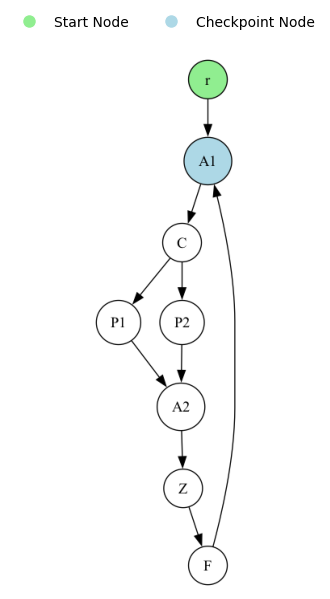

In [8]:
from humancompatible.interconnect.simulators.simulation import Simulation
sim = Simulation()

sim.system.add_nodes([refsig, agg1, agg2, cont, pop1, pop2, delay, fil])
sim.system.connect_nodes(refsig, agg1)
sim.system.connect_nodes(agg1, cont)
sim.system.connect_nodes(cont, pop1)
sim.system.connect_nodes(cont, pop2)
sim.system.connect_nodes(pop1, agg2)
sim.system.connect_nodes(pop2, agg2)
sim.system.connect_nodes(agg2, delay)
sim.system.connect_nodes(delay, fil)
sim.system.connect_nodes(fil, agg1)

sim.system.set_start_node(refsig)
sim.system.set_checkpoint_node(agg1)

sim.plot.render_graph()

In [9]:
import torch.nn as nn
model = sim.system.get_node("C").logic
sim.system.set_learning_model(model)
sim.system.set_loss_function(nn.L1Loss())
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
sim.system.set_optimizer(optimizer)

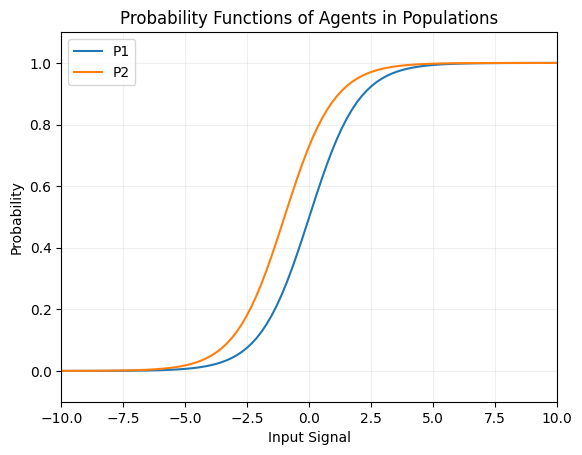

In [10]:
sim.plot.population_probabilities(xMin=-10, xMax=10)

In [11]:
sim.system.run(100, show_trace=False, show_loss=False)
# sim.system.run(20)

Running Control System:  29%|██▉       | 29/100 [00:00<00:00, 282.69it/s]

f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tenso

Running Control System: 100%|██████████| 100/100 [00:00<00:00, 261.21it/s]

f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.]])
f1_part:  tensor([[0.0010]])
f1_part:  tensor([[0.0010]])
f1_

In [12]:
cont.logic.eval()
cont.logic.state_dict(), cont.logic.kp.grad, cont.logic.ki.grad

(OrderedDict([('kp', tensor([0.1462])), ('ki', tensor([0.6184]))]),
 tensor([1.1945]),
 tensor([-501.6349]))

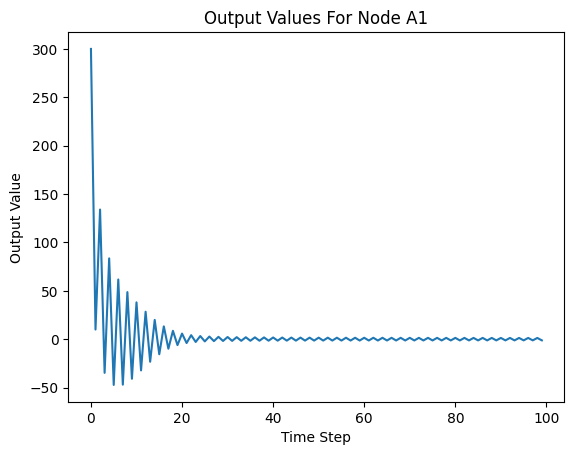

In [13]:
sim.plot.node_outputs(agg1)

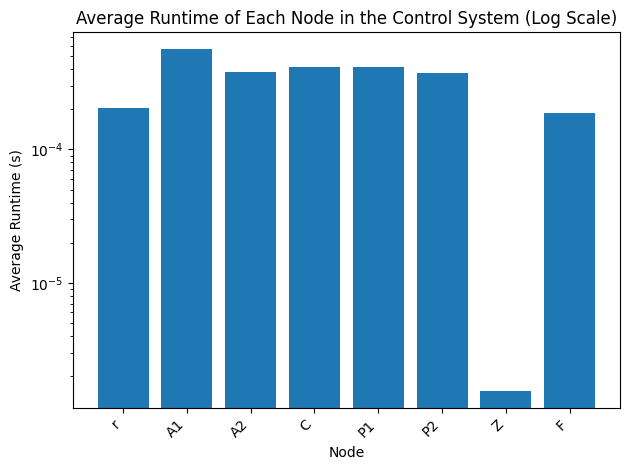

In [14]:
sim.plot.runtimes()

In [15]:
refsig.outputValue, agg1.outputValue, cont.outputValue, pop1.outputValue, agg2.outputValue, delay.outputValue, fil.outputValue

(tensor([300.], requires_grad=True),
 tensor([-1.1877], grad_fn=<UnsqueezeBackward0>),
 tensor([311.1827], grad_fn=<AddBackward0>),
 tensor([[301.1827]], grad_fn=<AddBackward0>),
 tensor([602.3754], grad_fn=<UnsqueezeBackward0>),
 tensor([602.3754], grad_fn=<UnsqueezeBackward0>),
 tensor([-301.1877], grad_fn=<DivBackward0>))

In [16]:
inputValue = (cont.logic.kp, cont.logic.ki, cont.logic.tensors["e"])
outputValue = fil.outputValue

torch.autograd.grad(inputs=inputValue, outputs=outputValue)

(tensor([-1.2989]), tensor([-502.9338]), tensor([-0.7645]))

In [17]:
from torchviz import make_dot

graph = make_dot(fil.logic.result, params=dict(refsig=refsig.outputValue, 
                                          result=agg1.logic.result,
                                          kp=cont.logic.kp,
                                          ki=cont.logic.ki,
                                          x=cont.logic.tensors["x"],
                                          s1=pop1.logic.tensors["s_const1"],
                                          s2=pop1.logic.tensors["s_const2"],
                                          K=fil.logic.tensors["K"],
                                          output=fil.logic.result))
graph.render("computation_graph", view=False)

'computation_graph.pdf'